# Web Scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

# Lists to store scraped data
reviews = []
aircraft = []
seat_type = []
route = []
type_of_traveller = []
date_flown = []
recommended = []
ratings = []

# DataFrame to store the structured data
df = pd.DataFrame()

for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL for the current page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    # Extract reviews and metadata
    for review in parsed_content.find_all("div", class_="body"):
        # Extract review text
        review_text = review.find("div", class_="text_content").get_text(strip=True)
        reviews.append(review_text)

        # Extract metadata
        metadata = review.find("div", class_="review-stats")
        metadata_dict = {}
        recommended_value = 'N/A'

        if metadata:
            for row in metadata.find_all('tr'):
                header_cell = row.find('td', class_='review-rating-header')
                value_cell = row.find('td', class_='review-value')
                
                if header_cell:
                    header = header_cell.get_text(strip=True)
                    if header == 'Recommended':
                        # Handle recommended field separately
                        if value_cell:
                            recommended_value = value_cell.get_text(strip=True)
                    else:
                        # Handle other metadata
                        if value_cell:
                            value = value_cell.get_text(strip=True)
                            metadata_dict[header] = value

            # Append metadata details
            aircraft.append(metadata_dict.get('Aircraft', 'N/A'))
            seat_type.append(metadata_dict.get('Seat Type', 'N/A'))
            route.append(metadata_dict.get('Route', 'N/A'))
            type_of_traveller.append(metadata_dict.get('Type Of Traveller', 'N/A'))
            date_flown.append(metadata_dict.get('Date Flown', 'N/A'))
            recommended.append(recommended_value)

            # Extract ratings
            rating_dict = {}
            for row in metadata.find_all('tr'):
                header_cell = row.find('td', class_='review-rating-header')
                stars_cell = row.find('td', class_='review-rating-stars stars')
                
                if header_cell:
                    header = header_cell.get_text(strip=True)
                    if stars_cell:
                        filled_stars = len(stars_cell.find_all('span', class_='star fill'))
                        rating_dict[header] = filled_stars
                    else:
                        rating_dict[header] = 'N/A'
            
            ratings.append(rating_dict)

    print(f"   ---> {len(reviews)} total reviews")

# Creating the DataFrame
df = pd.DataFrame({
    'reviews': reviews,
    'aircraft': aircraft,
    'seat_type': seat_type,
    'route': route,
    'type_of_traveller': type_of_traveller,
    'date_flown': date_flown,
    'recommended': recommended
})

# Flattening the ratings dictionary into separate columns
ratings_df = pd.json_normalize(ratings)
df = pd.concat([df, ratings_df], axis=1)

# Standardize column names
df.rename(columns={
    'Type Of Traveller': 'type_of_traveller',
    'Seat Type': 'seat_type',
    'Route': 'route',
    'Date Flown': 'date_flown',
    'Recommended': 'recommended',
    'Aircraft': 'aircraft',
    'Inflight Entertainment': 'inflight_entertainment',
    'Wifi & Connectivity': 'wifi_connectivity'
}, inplace=True)

# Remove duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Fill missing values or handle them appropriately
df.fillna('N/A', inplace=True)

# Reset index for clean DataFrame
df.reset_index(drop=True, inplace=True)

# Display the DataFrame or save to CSV
df.head()
df.to_csv('british_airways_reviews.csv', index=False)

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   reviews                 1000 non-null   object
 1   aircraft                1000 non-null   object
 2   seat_type               1000 non-null   object
 3   route                   1000 non-null   object
 4   type_of_traveller       1000 non-null   object
 5   date_flown              1000 non-null   object
 6   recommended             1000 non-null   object
 7   Seat Comfort            1000 non-null   object
 8   Cabin Staff Service     1000 non-null   object
 9   Food & Beverages        1000 non-null   object
 10  Ground Service          1000 non-null   object
 11  Value For Money         1000 non-null   int64 
 12  inflight_entertainment  1000 non-null   object
 13  wifi_connectivity       1000 non-null   object
dtypes: int64(1), object(13)
memory usage: 109.5+ KB


In [5]:
df.head()

,reviews,aircraft,seat_type,route,type_of_traveller,date_flown,recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,inflight_entertainment,wifi_connectivity
0,✅Trip Verified| When dropping off my luggage ...,N/A,Economy Class,Toulouse to London Heathrow,Family Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,N/A,N/A
1,✅Trip Verified| If you can’t fly First Class d...,Boeing 777,Economy Class,San Diego to London,Couple Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,1.0,N/A
2,Not Verified| Singapore to Heathrow. Busines...,A380-800,Business Class,Singapore to London,Family Leisure,July 2024,yes,3.0,2.0,3.0,5.0,2,3.0,N/A
3,Not Verified| I reported my damaged/ruined s...,N/A,Economy Class,Glasgow to Munich via Heathrow,Solo Leisure,June 2024,no,3.0,4.0,4.0,2.0,3,3.0,3.0
4,"Not Verified| On March 1st, I flew from Berl...",N/A,Economy Class,Berlin to São Paulo via London,Business,March 2024,no,3.0,4.0,3.0,1.0,2,3.0,3.0


In [6]:
df = pd.read_csv('british_airways_reviews.csv')

# Data Cleaning

In [7]:
df.shape

(1000, 14)

In [8]:
remove_text = ['✅ Trip Verified', 'Not Verified |']
def clean_review(review, text_to_remove):
    for text in text_to_remove:
        review = review.replace(text, '')
    return review.strip()
df['reviews'] = df['reviews'].apply(lambda x: clean_review(x, remove_text))

In [9]:
df

,reviews,aircraft,seat_type,route,type_of_traveller,date_flown,recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,inflight_entertainment,wifi_connectivity
0,✅Trip Verified| When dropping off my luggage ...,NaN,Economy Class,Toulouse to London Heathrow,Family Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,NaN,NaN
1,✅Trip Verified| If you can’t fly First Class d...,Boeing 777,Economy Class,San Diego to London,Couple Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,1.0,NaN
2,Not Verified| Singapore to Heathrow. Busines...,A380-800,Business Class,Singapore to London,Family Leisure,July 2024,yes,3.0,2.0,3.0,5.0,2,3.0,NaN
3,Not Verified| I reported my damaged/ruined s...,NaN,Economy Class,Glasgow to Munich via Heathrow,Solo Leisure,June 2024,no,3.0,4.0,4.0,2.0,3,3.0,3.0
4,"Not Verified| On March 1st, I flew from Berl...",NaN,Economy Class,Berlin to São Paulo via London,Business,March 2024,no,3.0,4.0,3.0,1.0,2,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,✅Trip Verified| London to Delhi. A truly firs...,NaN,First Class,London to Delhi,Couple Leisure,May 2019,yes,4.0,5.0,4.0,4.0,4,4.0,3.0
996,✅Trip Verified| London Heathrow to Dubai. Las...,NaN,Economy Class,London Heathrow to Dubai,Couple Leisure,May 2019,no,NaN,NaN,NaN,NaN,1,NaN,NaN
997,Not Verified| London to Seattle. My husband a...,Boeing 747,Economy Class,London to Seattle,Couple Leisure,May 2019,yes,4.0,5.0,4.0,5.0,5,NaN,NaN
998,✅Trip Verified| Johannesburg to London. I boo...,NaN,Economy Class,Johannesburg to London,Couple Leisure,May 2019,no,3.0,4.0,3.0,4.0,5,5.0,NaN


In [10]:
#Removing the parts before | in the reviews column
df.reviews= df.reviews.str.split('|',expand=True)[1]

In [11]:
df['reviews']

0        When dropping off my luggage at the luggage ...
1       If you can’t fly First Class don’t fly Britis...
2         Singapore to Heathrow. Business class on an...
3         I reported my damaged/ruined suitcase 5 wee...
4         On March 1st, I flew from Berlin to São Pau...
                             ...                        
995      London to Delhi. A truly first class experie...
996      London Heathrow to Dubai. Last Sunday we unf...
997      London to Seattle. My husband and I have use...
998      Johannesburg to London. I booked a seat with...
999      London to Milan. Evening outbound flight wit...
Name: reviews, Length: 1000, dtype: object

In [12]:
df

,reviews,aircraft,seat_type,route,type_of_traveller,date_flown,recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,inflight_entertainment,wifi_connectivity
0,When dropping off my luggage at the luggage ...,NaN,Economy Class,Toulouse to London Heathrow,Family Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,NaN,NaN
1,If you can’t fly First Class don’t fly Britis...,Boeing 777,Economy Class,San Diego to London,Couple Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,1.0,NaN
2,Singapore to Heathrow. Business class on an...,A380-800,Business Class,Singapore to London,Family Leisure,July 2024,yes,3.0,2.0,3.0,5.0,2,3.0,NaN
3,I reported my damaged/ruined suitcase 5 wee...,NaN,Economy Class,Glasgow to Munich via Heathrow,Solo Leisure,June 2024,no,3.0,4.0,4.0,2.0,3,3.0,3.0
4,"On March 1st, I flew from Berlin to São Pau...",NaN,Economy Class,Berlin to São Paulo via London,Business,March 2024,no,3.0,4.0,3.0,1.0,2,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,London to Delhi. A truly first class experie...,NaN,First Class,London to Delhi,Couple Leisure,May 2019,yes,4.0,5.0,4.0,4.0,4,4.0,3.0
996,London Heathrow to Dubai. Last Sunday we unf...,NaN,Economy Class,London Heathrow to Dubai,Couple Leisure,May 2019,no,NaN,NaN,NaN,NaN,1,NaN,NaN
997,London to Seattle. My husband and I have use...,Boeing 747,Economy Class,London to Seattle,Couple Leisure,May 2019,yes,4.0,5.0,4.0,5.0,5,NaN,NaN
998,Johannesburg to London. I booked a seat with...,NaN,Economy Class,Johannesburg to London,Couple Leisure,May 2019,no,3.0,4.0,3.0,4.0,5,5.0,NaN


In [13]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
df['Cleaned Reviews'] = df['reviews'].apply(clean)
df.head()

,reviews,aircraft,seat_type,route,type_of_traveller,date_flown,recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,inflight_entertainment,wifi_connectivity,Cleaned Reviews
0,When dropping off my luggage at the luggage ...,NaN,Economy Class,Toulouse to London Heathrow,Family Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,NaN,NaN,When dropping off my luggage at the luggage d...
1,If you can’t fly First Class don’t fly Britis...,Boeing 777,Economy Class,San Diego to London,Couple Leisure,July 2024,no,1.0,1.0,1.0,1.0,1,1.0,NaN,If you can t fly First Class don t fly Britis...
2,Singapore to Heathrow. Business class on an...,A380-800,Business Class,Singapore to London,Family Leisure,July 2024,yes,3.0,2.0,3.0,5.0,2,3.0,NaN,Singapore to Heathrow Business class on an A ...
3,I reported my damaged/ruined suitcase 5 wee...,NaN,Economy Class,Glasgow to Munich via Heathrow,Solo Leisure,June 2024,no,3.0,4.0,4.0,2.0,3,3.0,3.0,I reported my damaged ruined suitcase weeks a...
4,"On March 1st, I flew from Berlin to São Pau...",NaN,Economy Class,Berlin to São Paulo via London,Business,March 2024,no,3.0,4.0,3.0,1.0,2,3.0,3.0,On March st I flew from Berlin to S o Paulo w...


In [18]:
df_reviews = df[['reviews', 'Cleaned Reviews']].copy()

In [19]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
#The nltk.corpus package defines a collection of corpus reader classes, which can be used to access the contents of a diverse set of corpora.


nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
          #print(tag[0])
          #print(pos_dict.get(tag[0]))
    return newlist 

df_reviews['POS tagged'] = df_reviews['Cleaned Reviews'].apply(token_stop_pos)
df_reviews.head()

[nltk_data] Downloading package omw-1.4 to /Users/admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,reviews,Cleaned Reviews,POS tagged
0,When dropping off my luggage at the luggage ...,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d..."
1,If you can’t fly First Class don’t fly Britis...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (..."
2,Singapore to Heathrow. Business class on an...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),..."
3,I reported my damaged/ruined suitcase 5 wee...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su..."
4,"On March 1st, I flew from Berlin to São Pau...",On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ..."


In [21]:
# Obtaining the stem words – Lemmatization

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df_reviews['Lemma'] = df_reviews['POS tagged'].apply(lemmatize)
df_reviews.head()

,reviews,Cleaned Reviews,POS tagged,Lemma
0,When dropping off my luggage at the luggage ...,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d...",drop luggage luggage drop Toulouse airport t...
1,If you can’t fly First Class don’t fly Britis...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...
2,Singapore to Heathrow. Business class on an...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...
3,I reported my damaged/ruined suitcase 5 wee...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...
4,"On March 1st, I flew from Berlin to São Pau...",On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...


In [22]:
df_reviews[['reviews','Lemma']]

,reviews,Lemma
0,When dropping off my luggage at the luggage ...,drop luggage luggage drop Toulouse airport t...
1,If you can’t fly First Class don’t fly Britis...,fly First Class fly British Airways uncomfor...
2,Singapore to Heathrow. Business class on an...,Singapore Heathrow Business class Premium Ec...
3,I reported my damaged/ruined suitcase 5 wee...,report damaged ruin suitcase week ago still ...
4,"On March 1st, I flew from Berlin to São Pau...",March st fly Berlin Paulo BA encounter sever...
...,...,...
995,London to Delhi. A truly first class experie...,London Delhi truly first class experience ch...
996,London Heathrow to Dubai. Last Sunday we unf...,London Heathrow Dubai Last Sunday unfortunat...
997,London to Seattle. My husband and I have use...,London Seattle husband use service number ye...
998,Johannesburg to London. I booked a seat with...,Johannesburg London book seat without luggag...


# Sentiment Analysis using VADER
Vader sentiment not only tells if the statement is positive or negative along with the intensity of emotion.

In [23]:
!pip install vaderSentiment

In [24]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df_reviews['Sentiment'] = df_reviews['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df_reviews['Analysis'] = df_reviews['Sentiment'].apply(vader_analysis)
df_reviews.head()

,reviews,Cleaned Reviews,POS tagged,Lemma,Sentiment,Analysis
0,When dropping off my luggage at the luggage ...,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d...",drop luggage luggage drop Toulouse airport t...,0.9337,Positive
1,If you can’t fly First Class don’t fly Britis...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...,-0.9488,Negative
2,Singapore to Heathrow. Business class on an...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...,0.0498,Neutral
3,I reported my damaged/ruined suitcase 5 wee...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...,-0.6249,Negative
4,"On March 1st, I flew from Berlin to São Pau...",On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...,-0.9183,Negative


In [27]:
vader_counts = df_reviews['Analysis'].value_counts()
vader_counts

Positive    469
Negative    422
Neutral     109
Name: Analysis, dtype: int64

# Visual Representation 

([<matplotlib.patches.Wedge at 0x13e1189d0>,
 [Text(0.1069590031340875, 1.094787546352516, 'Positive'),
  Text(-0.46835717599151927, -0.9953097787609891, 'Negative'),
  Text(1.271619409691705, -0.45330351520291573, 'Neutral')],
 [Text(0.058341274436775, 0.5971568434650087, '46.9%'),
  Text(-0.25546755054082865, -0.5428962429605395, '42.2%'),
  Text(0.8006492579540364, -0.285413324387021, '10.9%')])

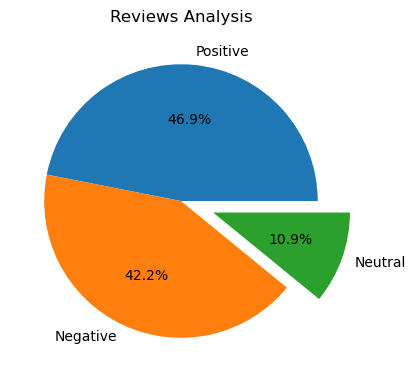

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

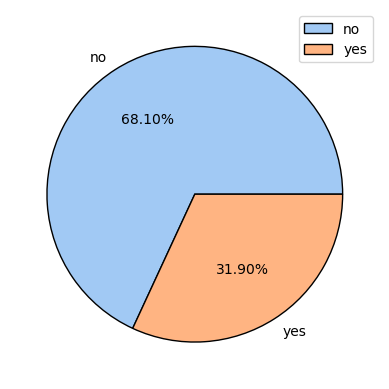

In [32]:
import seaborn as sns
soc = df.groupby('recommended')['reviews'].count().reset_index()
plt.pie(soc['reviews'], labels = soc['recommended'], autopct='%.2f%%',colors = sns.color_palette('pastel'),
          wedgeprops={"edgecolor":"k"},)
plt.legend()
plt.show()

In [41]:
#From the pie chart above, we know that 63.3% of passengers are dissatisfied with British Airways services. 
#let's breakdown the data to find what made passengers dissatisfied :
df_soc = df[df['recommended'] == 'no']
df_soc.describe()

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,inflight_entertainment,wifi_connectivity
count,593.000000,585.000000,482.000000,624.000000,681.000000,335.000000,211.000000
mean,2.086003,2.413675,1.852697,1.783654,1.524229,2.197015,1.516588
std,1.098689,1.311103,1.065955,1.163788,0.833005,1.241736,0.967796
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000
75%,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


1)Seat Comfort Insights: Seat comfort has a low average rating of 2.09, indicating generally poor satisfaction. The ratings are spread across the scale, with a standard deviation of 1.10.<br>

2)Cabin Staff Service: Insights: Cabin staff service is slightly better than seat comfort but still has a low average rating. The standard deviation suggests a wide variation in customer experiences.<br>

3)Food & Beverages: Insights: Food and beverages received very low ratings, with a mean of 1.85 and a median of 1, indicating general dissatisfaction.<br>

4)Ground Service: Insights: Ground service also received poor ratings, with a mean of 1.78. The majority of ratings are low, as indicated by the median of 1.<br>

5)Value for money Insights: Value for money is rated very low, with a mean of 1.52 and a small standard deviation, suggesting consistent dissatisfaction in this aspect.<br>

6)Inflight Entertainment: Insights: Inflight entertainment received mixed reviews, with an average rating slightly above 2, indicating moderate satisfaction.<br>

7)WiFi & Connectivity: Insights: WiFi and connectivity have a very low mean rating of 1.52, with most ratings being at the lower end, indicating significant dissatisfaction.<br>

Key areas of improvement - Value for Money, Food & Beverages, Ground Service, and WiFi & Connectivity are particularly low and require the most attention. 

# Wordcloud

In [34]:
pip install wordcloud 

Note: you may need to restart the kernel to use updated packages.


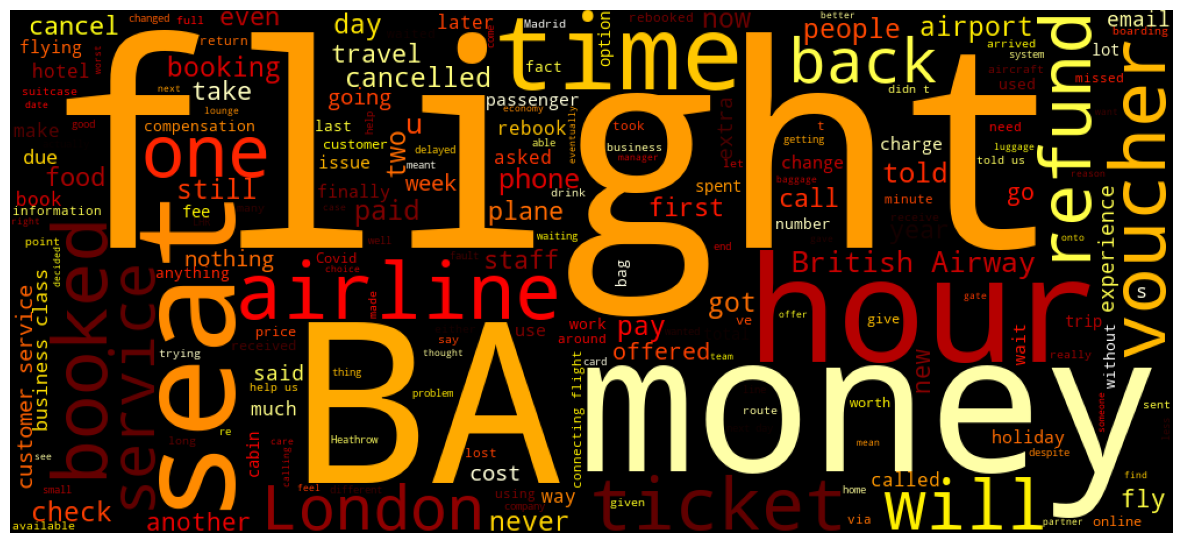

In [93]:
#Analysis value for money
data = df_soc[df_soc['reviews'].str.contains('money | refund & value')]
data['reviews'].to_csv('money.csv')

review_word = []

for i in data['reviews'] :
    a = i.split(' ')
    for x in a:
        review_word.append(x)
        
unique_string = (" ").join(review_word)

wc = WordCloud(width = 1000, height = 450,  colormap = 'hot',background_color ='black').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

Uncomfortable seat<br>
Delayed refund<br>
Voucher offers<br>
Customer service mixed reviews<br>
Flight cancellation<br>

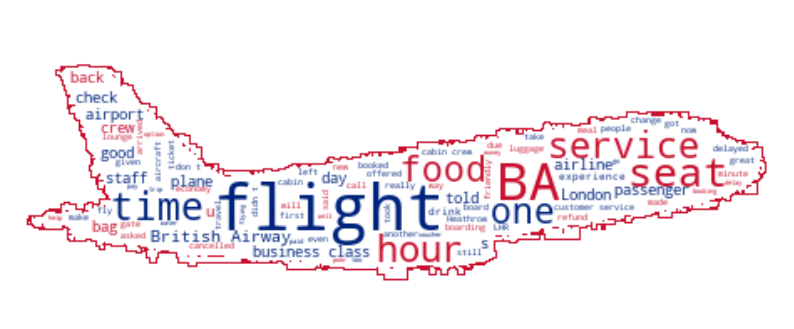

In [127]:
#British Airways themed Wordcloud :) 

text = " ".join(df_reviews['Cleaned Reviews'].astype(str))
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint

# Load the mask image
mask_image = np.array(Image.open('/Users/admin/Desktop/flight.png'))

# Define the color function
def british_airways_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ["#00247D", "#C8102E"]  # British Airways colors: blue, white, red
    return colors[randint(0, len(colors)-1)]

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask_image,
                      color_func=british_airways_color_func, contour_color='#C8102E', contour_width=1).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Topic Modelling

In [59]:
!pip install gensim spacy
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.1/839.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 12.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 13.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 10.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20430 sha256=c0817b48935d6ffdcbe56e02486f1f606adda08c9e7e28eb1214f088f7f62c2e
  Stored in directory: /Users/admin/Library/Caches/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3513 sha256=7b99375f7fcb7115c1dce36e5354aa2667a4c16708951843d203d57d

In [61]:
pd.reset_option('all')

/var/folders/h3/l62vyl2s2yz9qhggg2vbtd2m0000gn/T/ipykernel_23195/2786130087.py:1: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
/var/folders/h3/l62vyl2s2yz9qhggg2vbtd2m0000gn/T/ipykernel_23195/2786130087.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
/var/folders/h3/l62vyl2s2yz9qhggg2vbtd2m0000gn/T/ipykernel_23195/2786130087.py:1: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option('all')


In [63]:
import gensim
from gensim import corpora
import spacy

In [64]:
# Spacy model for English
nlp = spacy.load('en_core_web_sm')

In [68]:
# Tokenize and remove stop words, punctuation, and non-alphabetic tokens
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

# Apply the preprocessing function to the review column
df_reviews['tokens'] = df_reviews['Cleaned Reviews'].apply(preprocess)

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(df_reviews['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_reviews['tokens']]

In [69]:
from gensim.models import LdaModel

# Set the number of topics
num_topics = 5

# Create the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

# Print the topics with their keywords
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.024*"flight" + 0.014*"BA" + 0.012*"service" + 0.008*"check" + 0.008*"staff"')
(1, '0.023*"BA" + 0.019*"flight" + 0.014*"good" + 0.013*"service" + 0.010*"time"')
(2, '0.046*"flight" + 0.020*"BA" + 0.016*"hour" + 0.014*"cancel" + 0.012*"customer"')
(3, '0.027*"flight" + 0.013*"seat" + 0.011*"BA" + 0.009*"British" + 0.009*"Airways"')
(4, '0.028*"flight" + 0.020*"seat" + 0.017*"BA" + 0.011*"time" + 0.011*"t"')


In [72]:
# Get the topic distribution for each document
doc_topics = lda_model.get_document_topics(corpus)

# Calculate the proportion of each topic
topic_counts = [0] * num_topics
for doc in doc_topics:
    for topic_num, prop in doc:
        topic_counts[topic_num] += prop

# Normalize to get proportions
total_docs = len(corpus)
topic_proportions = [count / total_docs for count in topic_counts]
# Print the topic proportions
for i, proportion in enumerate(topic_proportions):
    print(f"Topic {i}: {proportion:.2%}")


Topic 0: 12.88%
Topic 1: 16.28%
Topic 2: 20.66%
Topic 3: 9.19%
Topic 4: 39.72%


In [75]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# Get the dominant topic for each review
dominant_topics = []
for doc in doc_topics:
    dominant_topic = max(doc, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

# Analyze sentiment for each review
sentiments = [get_sentiment_score(review) for review in reviews]

# Categorize sentiment into positive, negative, and neutral
sentiment_labels = []
for score in sentiments:
    if score > 0.05:
        sentiment_labels.append('Positive')
    elif score < -0.05:
        sentiment_labels.append('Negative')
    else:
        sentiment_labels.append('Neutral')

# Create a dataframe to combine topics and sentiments
import pandas as pd

df = pd.DataFrame({'Topic': dominant_topics, 'Sentiment': sentiment_labels})

# Calculate the proportion of each sentiment per topic
sentiment_distribution = df.groupby('Topic')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)

print(sentiment_distribution)

Sentiment  Negative   Neutral  Positive
Topic                                  
0          0.519380  0.031008  0.449612
1          0.329268  0.012195  0.658537
2          0.750000  0.020000  0.230000
3          0.630435  0.021739  0.347826
4          0.455422  0.007229  0.537349


### Drawing insight from topic modelling.<br>

1.General Service and Staff (Topic 0)<br>
Keywords: flight, BA, service, check, staff<br>
Proportion: 12.88%<br>
Insight: Significant focus on service quality and staff interactions. High negative sentiment (51.9%) indicates potential issues in staff behavior and overall service.<br>

2.Positive Feedback (Topic 1)<br>
Keywords: BA, flight, good, service, time<br>
Proportion: 16.28%<br>
Insight: Predominantly positive feedback (65.9%) on good service and timely flights, indicating satisfactory experiences for a portion of customers.<br>

3.Cancellations and Customer Service (Topic 2)<br>
Keywords: flight, BA, hour, cancel, customer
Proportion: 20.66%<br>
Insight: High negative sentiment (75%) related to cancellations and customer service issues, suggesting significant dissatisfaction in these areas.<br>

4.Flight Experience and Brand (Topic 3)<br>
Keywords: flight, seat, BA, British, Airways<br>
Proportion: 9.19%<br>
Insight: Mixed reviews on flight experience and brand mentions, with a notable negative sentiment (63%) indicating concerns about seating comfort or brand perception.<br>

5.Timing and Seat Comfort (Topic 4)<br>
Proportion: 39.72%<br>
Keywords: flight, seat, BA, time<br>
Insight: The most discussed topic, with a balanced sentiment but notable concerns about flight timing and seat comfort, indicating these are key areas for improvement.<br>